# Loan Application Approval Classifier

### The Data
 * `ds-credit.tsv` - File containing information about a customer's credit history.
 * `ds-app.tsv` - File containing information regarding the customer's loan application.
 * `ds-borrower.tsv` - File containing information regarding the customer's financial details.
 * `ds-result.tsv` - File containing the **actual** results of the loan application process.

### The Schema
<p>
The four files named above are our data sources. We can assume them to be **database tables** with schemas as illustrated below.
</p>
<br>
<img src="data_tables.JPG">
<br>
<p>
Clearly, the feature `CustomerId` is common across all these tables and is the **key** ID that ties them together. Since I am using Python for this project, I am going to combine these tables into a single table, before dividing my data into **training** and **testing** sets for my classifier. 
</p>
<p>
Before doing that however, we must read the files into Python. These files are **tab separated** files, opening them up in a text editor lets me know that they do not have headers. I assigned the headers from the project description to the relevant files in the text editor itself.
</p>

#### Loading the libraries

In [74]:
import os
import csv
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.figure(figsize=(16,10))
# plt.figure(figsize=(16, 10))
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

<Figure size 1152x720 with 0 Axes>

#### Setting the path

In [75]:
path = os.getcwd()
applicationFile = path + '/ds-app.tsv'
borrowerFile = path + '/ds-borrower.tsv'
creditFile = path + '/ds-credit.tsv'
resultFile = path + '/ds-result.tsv'

#### Data Manipulation

<p>
Let us use the pandas library to read the `application` data into a dataframe
</p>

In [76]:
applicationdf = pd.read_csv(applicationFile, sep='\t', header = 0)
applicationdf.head()

,CustomerID,LoanPayoffPeriodInMonths,LoanReason,RequestedAmount,InterestRate,Co-Applicant
0,741 36 goods 9566 2 none,NaN,NaN,NaN,NaN,NaN
1,439 12 goods 2279 4 none,NaN,NaN,NaN,NaN,NaN
2,501 30 auto 3857 4 none,NaN,NaN,NaN,NaN,NaN
3,147 12 auto 900 4 none,NaN,NaN,NaN,NaN,NaN
4,821 6 goods 1898 1 none,NaN,NaN,NaN,NaN,NaN


There are 2 interesting things to note - 
1. The data is **not** tab separated, but **space** separated as all the data have been incorrectly parsed into a single column.
2. The headers which I manually input into the files, correctly parse into separate columns.

To handle this problem -
* I will use the `csv` library to deal with the data row by row.
* This will lead to a row-based data structure, which is not conducive for data analysis. I will apply additional transformations to change the data to a column-based dataframe.
* It is safe to assume that the other datasets also face the same problem. To avoid checking those files individually and to save time, I will apply my solution uniformly across each file.

In [77]:
files = [applicationFile, borrowerFile, creditFile, resultFile]
holder = {}
for file in files:
    with open(file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        header = next(reader, None)
        table = []
        for row in reader:
            elements = row[0].split()
            table.append(elements)
        df = pd.DataFrame(table, columns = header)
        holder[file] = df
        del elements
        del df
        del table

<p>
In the code above, I transform each data table from a row-oriented structure to a column based pandas dataframe. I store those pandas dataframes in a temporary dictionary, indexed by the file names. I can now assign each pandas dataframe to its own variable and take a deeper dive into each data table.
</p>

In [78]:
applicationdf = holder[applicationFile]
borrowerdf = holder[borrowerFile]
creditdf = holder[creditFile]
resultdf = holder[resultFile]
del holder

<p>
We can now check if the correct data has been assigned to the correct variables.
</p>

In [79]:
applicationdf.head()

,CustomerID,LoanPayoffPeriodInMonths,LoanReason,RequestedAmount,InterestRate,Co-Applicant
0,741,36,goods,9566,2,none
1,439,12,goods,2279,4,none
2,501,30,auto,3857,4,none
3,147,12,auto,900,4,none
4,821,6,goods,1898,1,none


In [80]:
borrowerdf.head()

,CustomerID,YearsAtCurrentEmployer,YearsInCurrentResidence,Age,RentOrOwnHome,TypeOfCurrentEmployment,NumberOfDependantsIncludingSelf
0,765,1,1,46,rent,skilled,1
1,668,4,4,49,owned,skilled,1
2,68,10+,4,57,rent,skilled,1
3,805,4,2,41,owned,skilled,1
4,495,7,4,24,rent,skilled,1


In [81]:
creditdf.head()

,CustomerID,CheckingAccountBalance,DebtsPaid,SavingsAccountBalance,CurrentOpenLoanApplications
0,374,debt,paid,some,2
1,346,some,delayed,none,1
2,345,some,paid,none,1
3,243,some,delayed,some,1
4,662,debt,delayed,some,2


In [82]:
resultdf.head()

,CustomerID,WasTheLoanApproved
0,1,Y
1,2,Y
2,3,N
3,4,Y
4,5,Y


Now, we must combine or **join** these dataframes into a single dataframe, before we do that however, we must ensure that each of them has the same length. Doing so would bolster the following assumptions - 
* Each customer has only 1 row in each data table.
* The customers are uniform across each data table.

If the assumptions hold, we can simply combine the constituent tables into 1 big dataset.

In [83]:
print ("application   : ", applicationdf.shape)
print ("borrower      : ", borrowerdf.shape)
print ("credit        : ", creditdf.shape)
print ("result        : ", resultdf.shape)

application   :  (748, 6)
borrower      :  (749, 7)
credit        :  (749, 5)
result        :  (750, 2)


The results above tell us - 
* There are more `results` than `applications` $=>$ There are redundant customers in the `results`.
* There are more `results` than `borrower` and `credit`. This bolsters our above claim and we will have to remove these redundant customers from our analysis.
* There is at least one customer, for whom we do not have the `application` details but do have `borrower` and `credit` information. Now, without knowing important application features like the loan amount, duration or interest rate, we cannot make an accurate prediction as to whether they should be approved for a loan. We will have to find and remove this customer from our analysis.
* Conversely, it could be the case that 1 customer has 2 separate rows for `borrower` and `application`. In that case, we will have to decide which of the rows could play a greater role in our analysis and act accordingly.

In [84]:
applicationdf.set_index('CustomerID', inplace=True)
borrowerdf.set_index('CustomerID', inplace=True)
creditdf.set_index('CustomerID', inplace=True)
resultdf.set_index('CustomerID', inplace=True)

We set `CustomerID` as the index across all the dataframes and then use the `index.difference` method to check which `CustomerID` are absent from the `results` but present in the other dataframes. These `CustomerID` values will form our **blind test data**.

In [85]:
applicationdf.index.difference(resultdf.index)

Index(['751', '752', '753', '754', '755', '757', '758', '759', '760', '761',
       '762', '763', '765', '766', '767', '768', '769', '770', '771', '772',
       '773', '774', '775', '776', '777', '778', '780', '781', '782', '784',
       '785', '786', '788', '790', '791', '794', '795', '796', '797', '798',
       '799', '800', '801', '802', '803', '804', '805', '807', '810', '811',
       '812', '813', '814', '815', '816', '817', '818', '819', '820', '821',
       '822', '823', '824', '825', '827', '828', '829', '830', '831', '832',
       '833', '835', '836', '837', '838', '839', '840', '841', '842', '843',
       '844', '845', '846', '847', '848'],
      dtype='object', name='CustomerID')

In [86]:
borrowerdf.index.difference(resultdf.index)

Index(['751', '753', '754', '755', '756', '757', '758', '759', '760', '761',
       '762', '763', '764', '765', '766', '767', '768', '769', '770', '771',
       '772', '773', '774', '775', '776', '777', '778', '779', '780', '781',
       '782', '783', '784', '785', '786', '787', '788', '789', '790', '792',
       '793', '795', '796', '797', '799', '800', '801', '802', '803', '804',
       '805', '806', '807', '808', '809', '810', '811', '812', '813', '814',
       '815', '816', '817', '818', '819', '821', '822', '823', '824', '825',
       '826', '827', '828', '829', '830', '831', '832', '833', '835', '836',
       '837', '839', '840', '841', '842', '845', '846', '847', '848', '849'],
      dtype='object', name='CustomerID')

In [87]:
creditdf.index.difference(resultdf.index)

Index(['751', '753', '754', '755', '756', '758', '759', '761', '762', '764',
       '765', '766', '767', '768', '769', '770', '771', '772', '773', '775',
       '776', '777', '778', '779', '780', '781', '782', '783', '784', '785',
       '786', '787', '788', '789', '790', '791', '792', '793', '794', '795',
       '796', '797', '798', '799', '800', '801', '802', '804', '806', '807',
       '808', '809', '810', '811', '812', '813', '814', '816', '817', '818',
       '819', '821', '822', '823', '824', '825', '826', '827', '829', '830',
       '831', '832', '833', '834', '835', '836', '837', '838', '839', '840',
       '841', '842', '843', '844', '845', '846', '847', '848', '849'],
      dtype='object', name='CustomerID')

As we can see, the `customerID` values from $751$ onwards do not have `results`. These form our blind test data. Let us now join these data frames together. We perform these steps to join the data - 
* **Left outer join** `application` data with `borrower` data, this ensures that we retain only customers who have valid applications.
* **Left outer join** the above table with `credit` data.
* **Left outer join** the above table with the `result` data.

In [88]:
join1 = pd.merge(applicationdf,
                  borrowerdf,
                  right_index=True,
                  left_index=True,
                  how = 'left')
join1.shape

(748, 11)

In [89]:
join2 = pd.merge(join1,
                  creditdf,
                  right_index=True,
                  left_index=True,
                  how = 'left')
join2.shape

(748, 15)

In [90]:
join3 = pd.merge(join2,
                  resultdf,
                  right_index=True,
                  left_index=True,
                  how = 'left')
join3.shape

(748, 16)

In [91]:
join3.index = join3.index.map(int)
join3.sort_index(inplace=True)
join3.head()

,LoanPayoffPeriodInMonths,LoanReason,RequestedAmount,InterestRate,Co-Applicant,YearsAtCurrentEmployer,YearsInCurrentResidence,Age,RentOrOwnHome,TypeOfCurrentEmployment,NumberOfDependantsIncludingSelf,CheckingAccountBalance,DebtsPaid,SavingsAccountBalance,CurrentOpenLoanApplications,WasTheLoanApproved
CustomerID,,,,,,,,,,,,,,,,
2,9,goods,3074,1,none,4,2,33,owned,skilled,2,none,delayed,none,2,Y
3,12,auto,939,4,none,7,2,28,owned,skilled,1,high,delayed,high,3,N
4,9,auto,2507,2,none,10+,4,51,free,unskill,1,none,paid,high,1,Y
5,18,goods,2238,2,none,4,1,25,owned,skilled,1,none,delayed,some,2,Y
6,24,repairs,5507,3,none,10+,4,44,free,skilled,1,none,delayed,some,2,Y


## Exploratory Data Analysis

Now that we have our data in one combined dataset, we still have to -
* Split our data into **training**, **testing** and **blind test** datasets.
* Explore our data visually to find - 
    * Missing Values.
    * Data imbalance.
    * Visual patterns that show relationships.

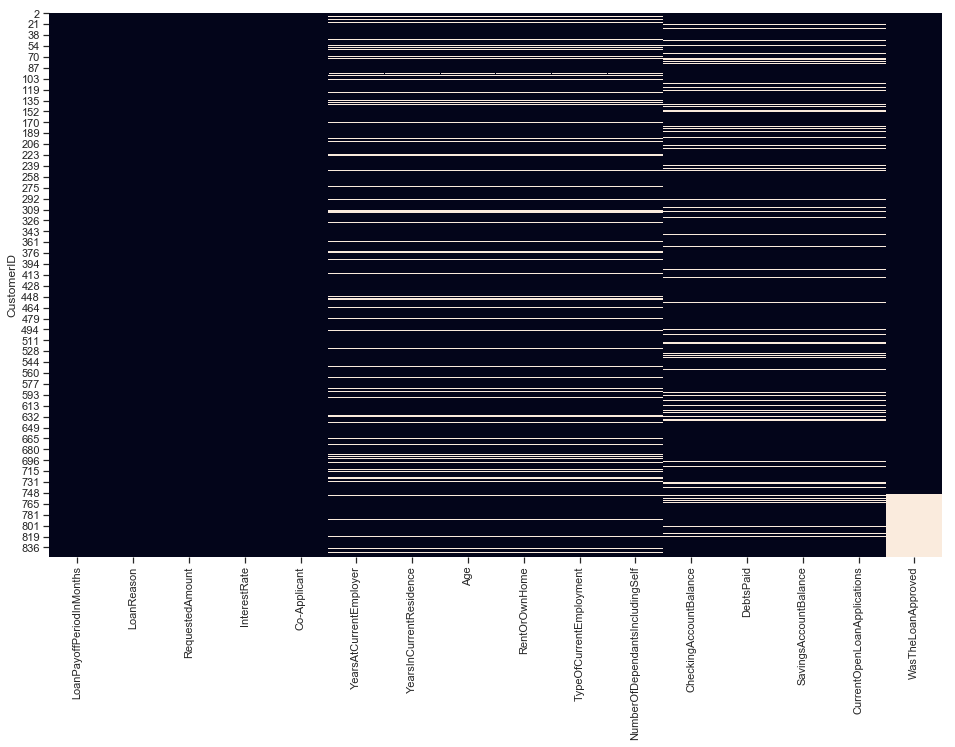

In [92]:
sns.heatmap(join3.isnull(), cbar=False)

The plot above shows us missing values in the joined dataset. Let us look at `WasTheLoanApproved`, it has a solid chunk of missing values towards the end of the dataset. This chunk forms our **blind test data**.

Before we split our data, let us ensure that the data types are as expected

In [93]:
join3.dtypes

LoanPayoffPeriodInMonths           object
LoanReason                         object
RequestedAmount                    object
InterestRate                       object
Co-Applicant                       object
YearsAtCurrentEmployer             object
YearsInCurrentResidence            object
Age                                object
RentOrOwnHome                      object
TypeOfCurrentEmployment            object
NumberOfDependantsIncludingSelf    object
CheckingAccountBalance             object
DebtsPaid                          object
SavingsAccountBalance              object
CurrentOpenLoanApplications        object
WasTheLoanApproved                 object
dtype: object

We need to map these values to the correct datatype. The columns that are numeric need to be explicitly converted to numeric, we can leave the columns that are strings alone.

In [94]:
join3[["LoanPayoffPeriodInMonths","RequestedAmount","InterestRate",
       "YearsInCurrentResidence","Age","NumberOfDependantsIncludingSelf",
       "CurrentOpenLoanApplications"]] = join3[["LoanPayoffPeriodInMonths","RequestedAmount","InterestRate",
                                                "YearsInCurrentResidence","Age","NumberOfDependantsIncludingSelf",
                                                "CurrentOpenLoanApplications"]].apply(pd.to_numeric)
join3.dtypes

LoanPayoffPeriodInMonths             int64
LoanReason                          object
RequestedAmount                      int64
InterestRate                         int64
Co-Applicant                        object
YearsAtCurrentEmployer              object
YearsInCurrentResidence            float64
Age                                float64
RentOrOwnHome                       object
TypeOfCurrentEmployment             object
NumberOfDependantsIncludingSelf    float64
CheckingAccountBalance              object
DebtsPaid                           object
SavingsAccountBalance               object
CurrentOpenLoanApplications        float64
WasTheLoanApproved                  object
dtype: object

In [95]:
blindTestdf = join3[join3['WasTheLoanApproved'].isnull()]
blindTestdf.shape

(85, 16)

In [96]:
combineddf = join3[-join3['WasTheLoanApproved'].isnull()]
combineddf.shape

(663, 16)

Our blind test data has $85$ datapoints, now, ideally we would like a $75:25$ training-test split. Keep in mind that we now have a total of $663$ data points. We will have to split this data to get the **training** and **testing** datasets. We will train our model on the training data, test it on our testing dataset and make predictions for the blind dataset.

In [97]:
del join1
del join2
del join3

In [98]:
from sklearn.model_selection import train_test_split

# y = combineddf['WasTheLoanApproved']
# x_train, x_test, y_train, y_test = train_test_split(combineddf, y, test_size = 0.25)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

train, test = train_test_split(combineddf, test_size = 0.25)
print(train.shape, test.shape)

(497, 16) (166, 16)


### Handling missing data

Let us now explore the missing data values in our dataset. First let us look at what fraction of our data is missing.

In [99]:
round(train.isnull().sum()/train.shape[0] * 100, 2)

LoanPayoffPeriodInMonths            0.00
LoanReason                          0.00
RequestedAmount                     0.00
InterestRate                        0.00
Co-Applicant                        0.00
YearsAtCurrentEmployer             11.47
YearsInCurrentResidence            11.47
Age                                11.47
RentOrOwnHome                      11.47
TypeOfCurrentEmployment            11.47
NumberOfDependantsIncludingSelf    11.47
CheckingAccountBalance             10.66
DebtsPaid                          10.66
SavingsAccountBalance              10.66
CurrentOpenLoanApplications        10.66
WasTheLoanApproved                  0.00
dtype: float64

In [100]:
round(test.isnull().sum()/test.shape[0] * 100, 2)

LoanPayoffPeriodInMonths            0.00
LoanReason                          0.00
RequestedAmount                     0.00
InterestRate                        0.00
Co-Applicant                        0.00
YearsAtCurrentEmployer             12.65
YearsInCurrentResidence            12.65
Age                                12.65
RentOrOwnHome                      12.65
TypeOfCurrentEmployment            12.65
NumberOfDependantsIncludingSelf    12.65
CheckingAccountBalance             15.06
DebtsPaid                          15.06
SavingsAccountBalance              15.06
CurrentOpenLoanApplications        15.06
WasTheLoanApproved                  0.00
dtype: float64

In [101]:
round(blindTestdf.isnull().sum()/blindTestdf.shape[0] * 100, 2)

LoanPayoffPeriodInMonths             0.00
LoanReason                           0.00
RequestedAmount                      0.00
InterestRate                         0.00
Co-Applicant                         0.00
YearsAtCurrentEmployer               9.41
YearsInCurrentResidence              9.41
Age                                  9.41
RentOrOwnHome                        9.41
TypeOfCurrentEmployment              9.41
NumberOfDependantsIncludingSelf      9.41
CheckingAccountBalance              11.76
DebtsPaid                           11.76
SavingsAccountBalance               11.76
CurrentOpenLoanApplications         11.76
WasTheLoanApproved                 100.00
dtype: float64

In both our data sets, the $\%$age of missing values ranges from $9\% - 12\%$. We can handle missing values in the following ways - 
* **The easy way** - Remove them from our data.
* **The proper way** - Impute the mean values for numerical data and most common value for string data.

At $9\% - 12\%$, and with the few datapoints that we have, we cannot afford to remove the missing data if we wish to make a strong classifier. We separate the data by `numeric` and `object` type and then apply our strategies. Note, the datasets were joined in a way that only valid applications would be considered, therefore, the columns in `applicationdf` do not have missing values, we can exclude these columns from the missing data imputation process.

In [102]:
num_dtypes = [i for i in train.select_dtypes(include = np.number).columns if i not in applicationdf.columns]
obj_dtypes = [i for i in train.select_dtypes(include = np.object).columns if i not in applicationdf.columns]
obj_dtypes = [x for x in obj_dtypes if x != 'WasTheLoanApproved']

In [103]:
num_dtypes

['YearsInCurrentResidence',
 'Age',
 'NumberOfDependantsIncludingSelf',
 'CurrentOpenLoanApplications']

In [104]:
obj_dtypes

['YearsAtCurrentEmployer',
 'RentOrOwnHome',
 'TypeOfCurrentEmployment',
 'CheckingAccountBalance',
 'DebtsPaid',
 'SavingsAccountBalance']

We handle missing data as follows - 
* For numerical features we impute the **median** value of the data to the missing values.
* For strings, we impute the most common value (**mode**) of the data to the missing values.

Let us handle the numerical data types first.

In [105]:
table = PrettyTable()
table.field_names = ["Feature", "Mean", "Median"]
for col in num_dtypes:
    table.add_row([col, round(train[col].mean(), 3), train[col].median()])
print(table)

+---------------------------------+--------+--------+
|             Feature             |  Mean  | Median |
+---------------------------------+--------+--------+
|     YearsInCurrentResidence     | 2.795  |  3.0   |
|               Age               | 35.677 |  34.0  |
| NumberOfDependantsIncludingSelf | 1.155  |  1.0   |
|   CurrentOpenLoanApplications   | 1.428  |  1.0   |
+---------------------------------+--------+--------+


Since the median value is quite close to the mean, and conveniently, a whole number, we will use the it to impute the missing values for numerical features. We will also create 2 new dataframes to hold our train and test sets.

In [106]:
train_new  = train[[i for i in train.columns if i not in num_dtypes + obj_dtypes]]
test_new  = test[[i for i in test.columns if i not in num_dtypes + obj_dtypes]]
blind_new = blindTestdf[[i for i in blindTestdf.columns if i not in num_dtypes + obj_dtypes]]

In [107]:
for j, col in enumerate(num_dtypes):
    train_new[j] = train[col].fillna(int(train[col].median()))
    train_new = train_new.rename(columns = {j: col})
    test_new[j] = test[col].fillna(int(test[col].median()))
    test_new = test_new.rename(columns = {j: col})
    blind_new[j] = blindTestdf[col].fillna(int(blindTestdf[col].median()))
    blind_new = blind_new.rename(columns = {j: col})

We will now handle the features with string/object data type.

In [108]:
for k, col in enumerate(obj_dtypes):
    train_new[k] = train[col].fillna(train[col].mode()[0])
    train_new = train_new.rename(columns={k: col})
    test_new[k] = test[col].fillna(test[col].mode()[0])
    test_new = test_new.rename(columns={k: col})
    blind_new[j] = blindTestdf[col].fillna(blindTestdf[col].mode()[0])
    blind_new = blind_new.rename(columns = {j: col})

In [109]:
train_new.isnull().sum()

LoanPayoffPeriodInMonths           0
LoanReason                         0
RequestedAmount                    0
InterestRate                       0
Co-Applicant                       0
WasTheLoanApproved                 0
YearsInCurrentResidence            0
Age                                0
NumberOfDependantsIncludingSelf    0
CurrentOpenLoanApplications        0
YearsAtCurrentEmployer             0
RentOrOwnHome                      0
TypeOfCurrentEmployment            0
CheckingAccountBalance             0
DebtsPaid                          0
SavingsAccountBalance              0
dtype: int64

In [110]:
test_new.isnull().sum()

LoanPayoffPeriodInMonths           0
LoanReason                         0
RequestedAmount                    0
InterestRate                       0
Co-Applicant                       0
WasTheLoanApproved                 0
YearsInCurrentResidence            0
Age                                0
NumberOfDependantsIncludingSelf    0
CurrentOpenLoanApplications        0
YearsAtCurrentEmployer             0
RentOrOwnHome                      0
TypeOfCurrentEmployment            0
CheckingAccountBalance             0
DebtsPaid                          0
SavingsAccountBalance              0
dtype: int64

In [111]:
blind_new.isnull().sum()

LoanPayoffPeriodInMonths            0
LoanReason                          0
RequestedAmount                     0
InterestRate                        0
Co-Applicant                        0
WasTheLoanApproved                 85
YearsInCurrentResidence             0
Age                                 0
NumberOfDependantsIncludingSelf     0
CurrentOpenLoanApplications         0
YearsAtCurrentEmployer              0
RentOrOwnHome                       0
TypeOfCurrentEmployment             0
CheckingAccountBalance              0
DebtsPaid                           0
SavingsAccountBalance               0
dtype: int64

For the blind test data, we replace the `Nan`s in `WasTheLoanApproved` with 0. That will help us pass the data to the classifier model, which will then make the predictions for what it believes the values should be for `WasTheLoanApproved`.

In [112]:
blind_new["WasTheLoanApproved"].fillna(0, inplace=True)
blind_new.head()

,LoanPayoffPeriodInMonths,LoanReason,RequestedAmount,InterestRate,Co-Applicant,WasTheLoanApproved,YearsInCurrentResidence,Age,NumberOfDependantsIncludingSelf,CurrentOpenLoanApplications,YearsAtCurrentEmployer,RentOrOwnHome,TypeOfCurrentEmployment,CheckingAccountBalance,DebtsPaid,SavingsAccountBalance
CustomerID,,,,,,,,,,,,,,,,
751,12,goods,804,4,none,0,4.0,38.0,1.0,1.0,10+,owned,skilled,none,paid,some
752,11,auto,3939,1,none,0,4.0,35.0,1.0,1.0,4,owned,skilled,none,paid,some
753,24,goods,2828,4,none,0,4.0,22.0,1.0,1.0,4,owned,skilled,debt,paid,high
754,48,busin,3844,4,none,0,4.0,34.0,2.0,1.0,7,free,unskill,some,paid,medium
755,9,goods,1126,2,none,0,4.0,49.0,1.0,1.0,10+,owned,skilled,high,paid,medium


We have successfully *approximated* the missing values. Let us now check if the data is **unbalanced**. Class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learning a model that optimizes the predictions based on the majority class in the dataset. As a result, we’ll explore methods to handle the class imbalance problem.

Positive examples :  455
Negative examples :  207
Proportion of negative to positive examples :  45.0 %
Proportion of negative to total examples :  31.0 %


Text(0.5, 1, 'Class counts')

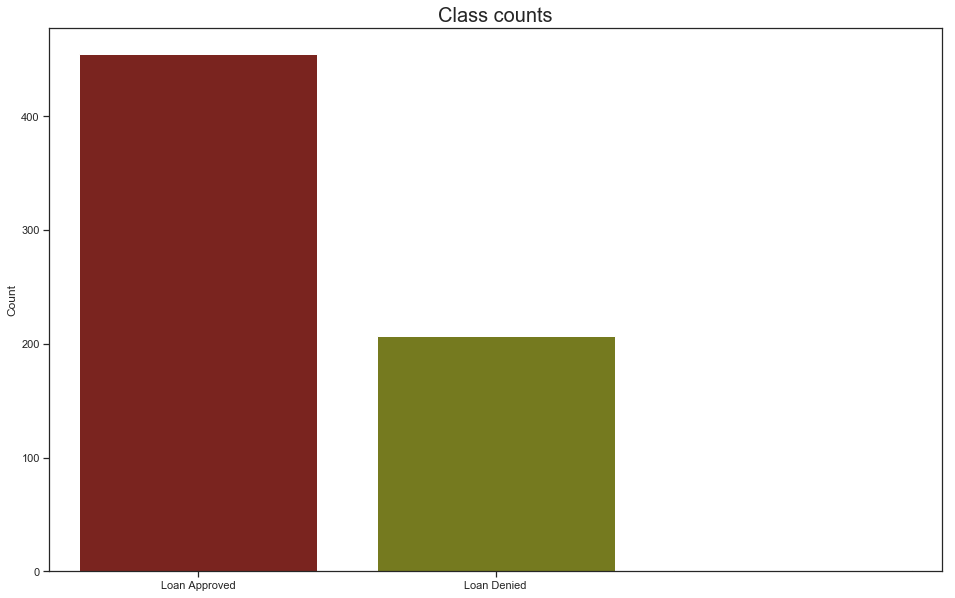

In [113]:
combineddf.drop(combineddf[combineddf.WasTheLoanApproved == 1].index, inplace=True)
approved = combineddf[combineddf["WasTheLoanApproved"] == 'Y'].shape[0]
denied = combineddf[combineddf["WasTheLoanApproved"] == 'N'].shape[0]
print("Positive examples : ", approved)
print("Negative examples : ", denied)
print("Proportion of negative to positive examples : ", round(denied/approved, 2) * 100, "%")
print("Proportion of negative to total examples : ", round(denied/combineddf.shape[0], 2) * 100, "%")
sns.countplot(combineddf["WasTheLoanApproved"])
plt.xticks((0, 1), ["Loan Approved", "Loan Denied"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1 ,fontdict={"fontsize": 20})

Classification problems in most real world applications have imbalanced data sets. As we can see, there exists an imbalance between the positive (loan approved) examples (majority class) and the negative (loan denied) examples (minority class). In our example, the negative examples form only 31% of the total examples. Therefore, accuracy is no longer a good measure of performance for different models because if we simply predict all examples to belong to the positive class, we achieve 69% accuracy. 
Therefore, better metrics for imbalanced data sets are **AUC** (area under the ROC curve) and **f1-score**. Since, the dataset is imbalanced, but not too skewed, we will make our classifiers without using sampling methods.

### Visualizing our Data

Now that we have handled missing data, we can now get started with the core of our task, building and evaluating the model. To assist in that process, let us explore our data visually to get a deeper understanding of our features and how they relate to our target variable `WasTheLoanApproved`.

In [114]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.set_style("ticks")
# sns.set_palette("dark")
# sns.set_palette("Paired")
sns.set_palette(sns.hls_palette(6, l=.3, s=.8))


The above snippet of code sets our parameters for seaborn plots.

In [115]:
train_new.WasTheLoanApproved.replace(('Y', 'N'), (1, 0), inplace=True)
test_new.WasTheLoanApproved.replace(('Y', 'N'), (1, 0), inplace=True)

train_new[['WasTheLoanApproved']] = train_new[['WasTheLoanApproved']].apply(pd.to_numeric)
test_new[['WasTheLoanApproved']] = test_new[['WasTheLoanApproved']].apply(pd.to_numeric)

# blind_new.WasTheLoanApproved.replace(('Y', 'N'), (1, 0), inplace=True)
# blind_new[['WasTheLoanApproved']] = blind_new[['WasTheLoanApproved']].apply(pd.to_numeric)

Here are some questions that come to mind when we look at the loan data - 
* **Who?** - What generally describes the people applying for a loan?
* **Why?** - What is driving them to take apply for a loan?
* **Amount?** - In general, how much are the applicants looking to borrow and at what interest rates?
* **Time?** - What is, in general, the duration of the loan payment period?
* **Should we?** - Do they pose a risk of failing to pay their loan?
* And finally, are there patterns that indicate which factors contribute to the decision of whether to approve or deny an applicant?

All these questions are very general, but we can get a high level answer to these questions by making some plots. For example, to get an idea of who is applying for these loans, we can explore
* The distribution of their ages.
* Whether they are applying alone.
* Whether they rent/own their homes.
* Their employment types.

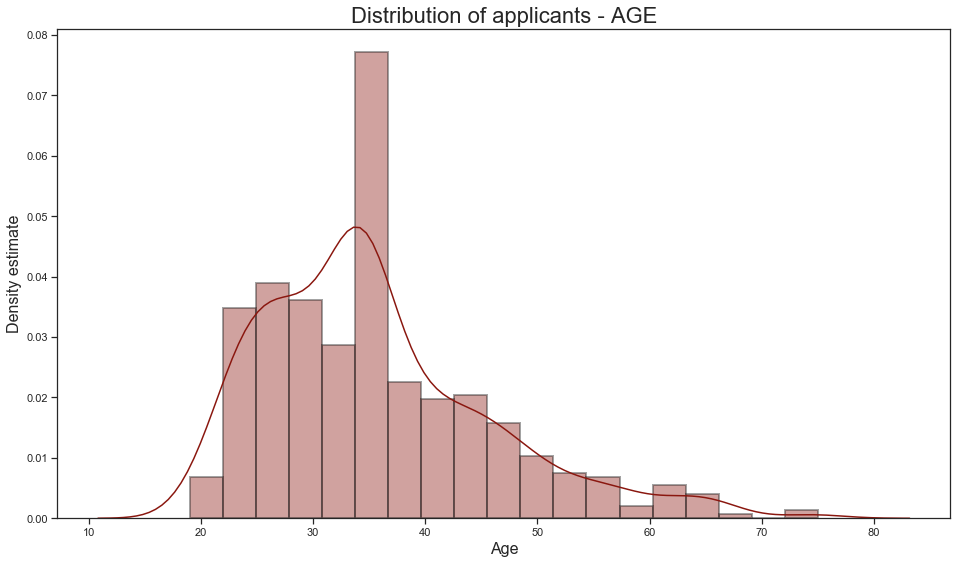

In [116]:
sns.distplot(train_new['Age'], hist_kws=dict(edgecolor="k", linewidth=2))
plt.ylabel("Density estimate", fontsize = 16)
plt.xlabel('Age', fontsize = 16)
plt.title("Distribution of applicants - AGE", fontsize = 22)
plt.show()

The bulk of applicants seem to be under $40$, with $25-38$ accounting for the largest segment. Now let's see if `Age` has any impact on `WasTheLoanApproved`.

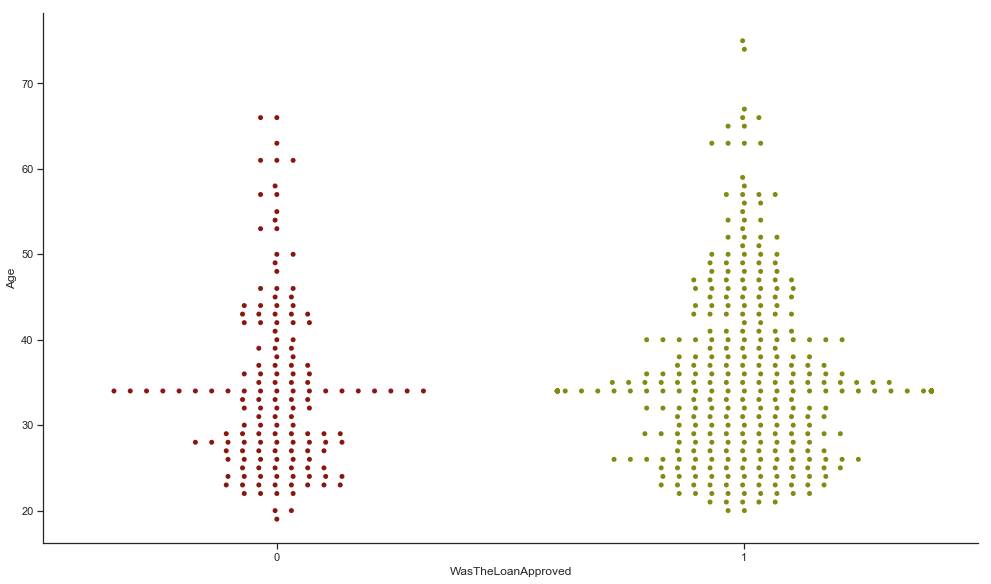

In [117]:
g = sns.catplot(x = "WasTheLoanApproved", y = "Age", kind = "swarm", data = train_new)
g.fig.set_size_inches(16, 9)

Since both groups are visually similar, it is difficult to say if `Age` played a decision in the loan approval process from this graphic alone. Let's explore `Co-Applicant` and see if applying with a `Co-Applicant` improves an applicant's odds of approval.

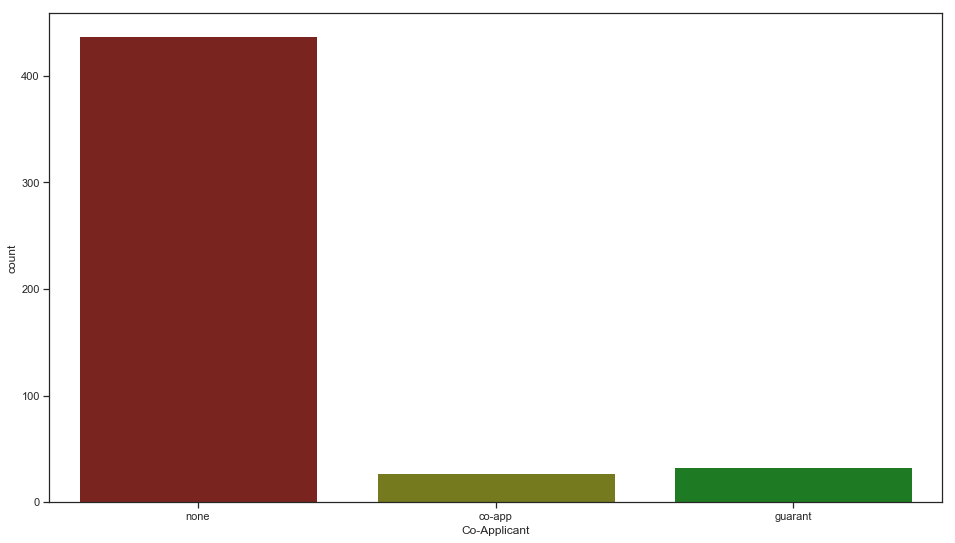

In [118]:
sns.countplot(train_new["Co-Applicant"])

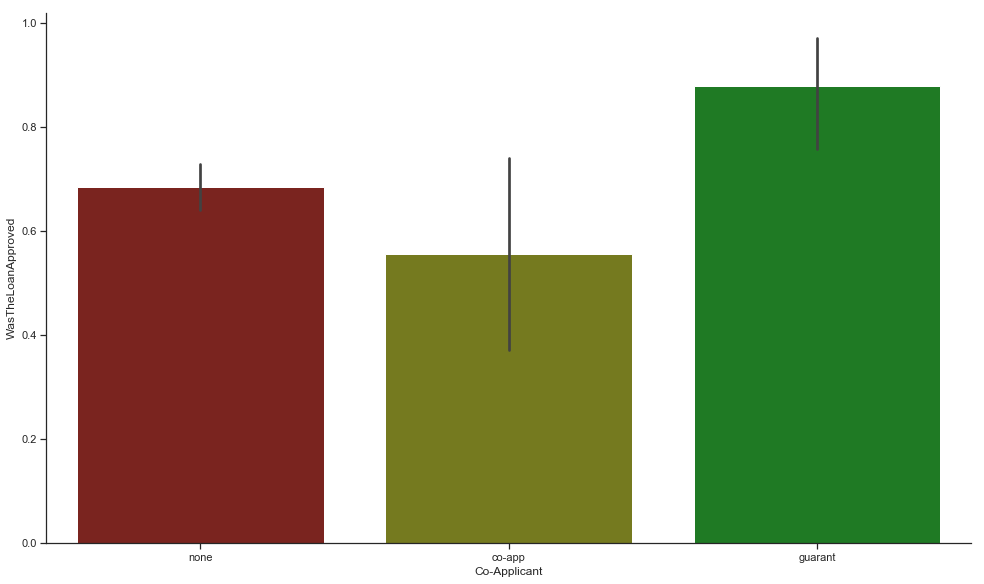

In [119]:
g = sns.catplot(x = "Co-Applicant", y = "WasTheLoanApproved", kind="bar", data = train_new)
g.fig.set_size_inches(16, 9)

As we can see, the vast majority of applicants apply for a loan by themselves. However, applying with a guarantor improves your chances of approval. Let us pair this with `Age`. This will help add more weight to our assumption.

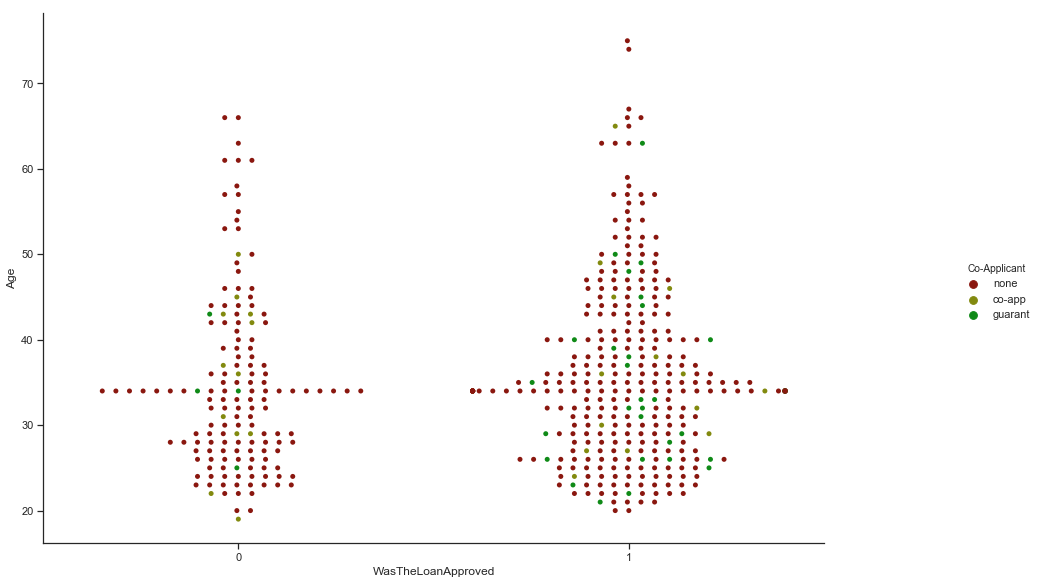

In [120]:
g = sns.catplot(x = "WasTheLoanApproved", y = "Age", hue = "Co-Applicant", kind = "swarm", data = train_new)
g.fig.set_size_inches(16, 9)

As we can see, the number of `guarant` points for rejected applicants is much lower than those for approved applicants. Having a guarantor as a `Co-Applicant` certainly seems to have an impact on our target variable. Let us now explore whether our applicants rent/own there homes and what role that feature may play in our analysis.

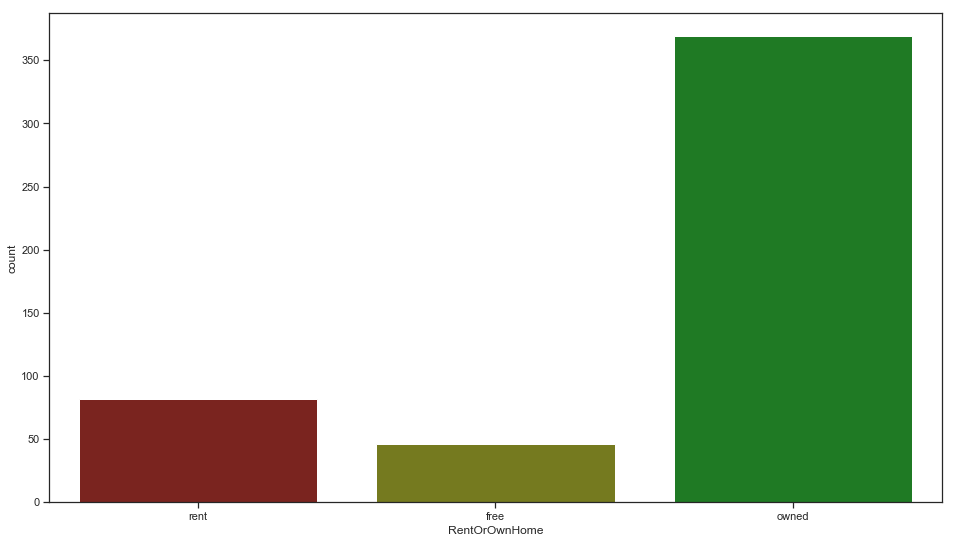

In [121]:
sns.countplot(train_new["RentOrOwnHome"])

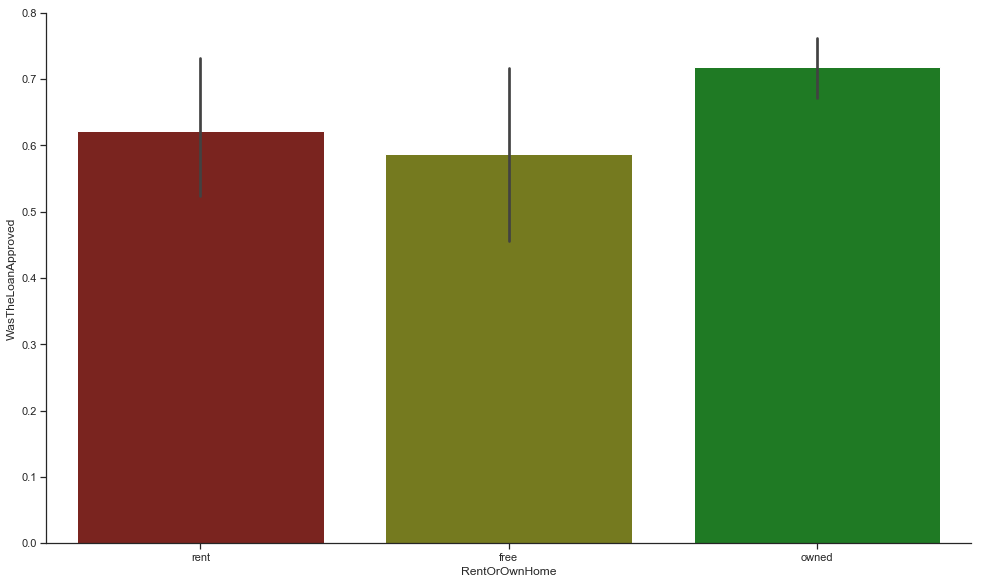

In [122]:
g = sns.catplot(x = "RentOrOwnHome", y = "WasTheLoanApproved", kind="bar", data = train_new)
g.fig.set_size_inches(16, 9)

Owning a home seems to have an impact on our target variable. Let us now explore what kind of employment types our applicants have and what role that feature may play in our analysis.

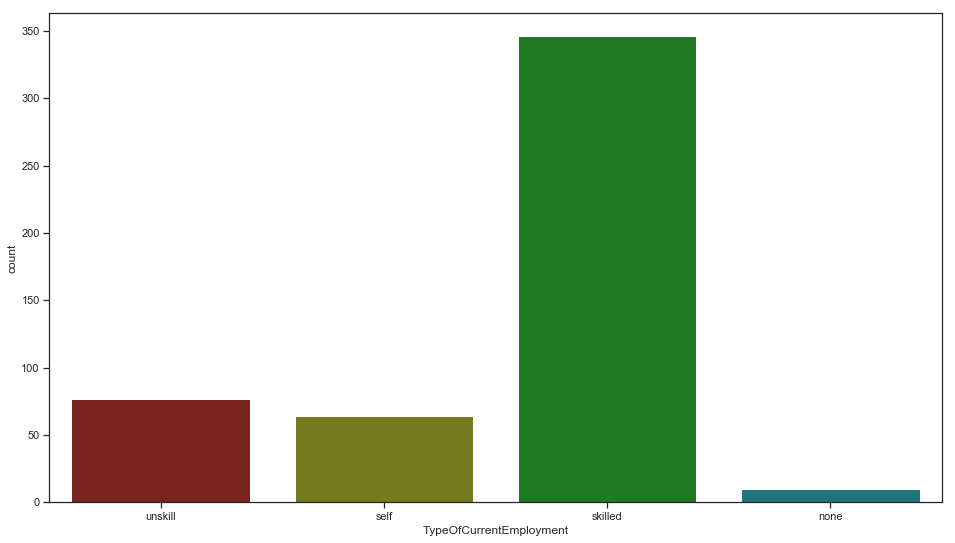

In [123]:
sns.countplot(train_new["TypeOfCurrentEmployment"])

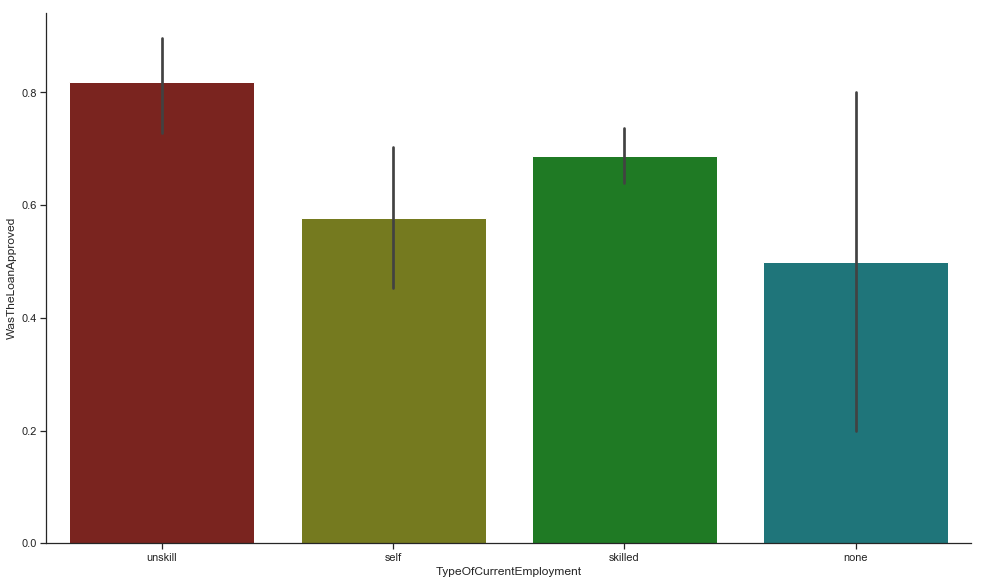

In [124]:
g = sns.catplot(x = "TypeOfCurrentEmployment", y = "WasTheLoanApproved", kind="bar", data = train_new)
g.fig.set_size_inches(16, 9)

Let us explore this further by pairing this data with `Age` and `RequestedAmount`.

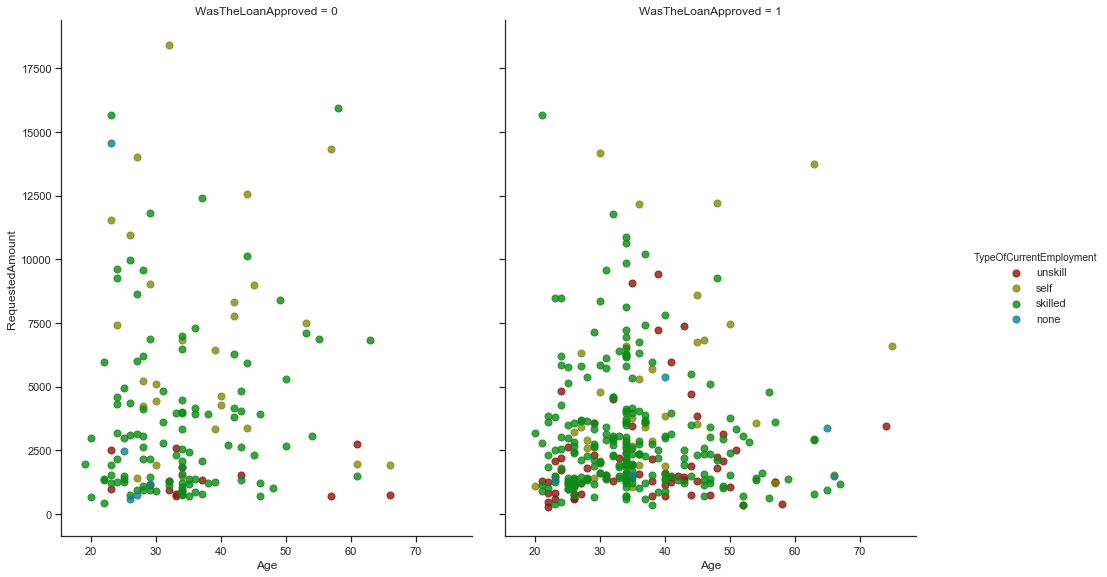

In [125]:
g = sns.lmplot(data = train_new, x = "Age", y = "RequestedAmount", 
               hue = "TypeOfCurrentEmployment", col="WasTheLoanApproved",
               scatter_kws = {'s':50}, fit_reg=False)
g.fig.set_size_inches(16, 9)

This plot doesn't tell us much apart from -
* Self employed applicants who get rejected apply for larger amounts than other employment type applicants. When self-employed applicants apply for lesser amounts (< $\$7500$), they have a greater chance of approval.
* Younger applicants, irrespective of employment type have a good likelihood of being rejected if they apply for large amounts (> $\$7500$)

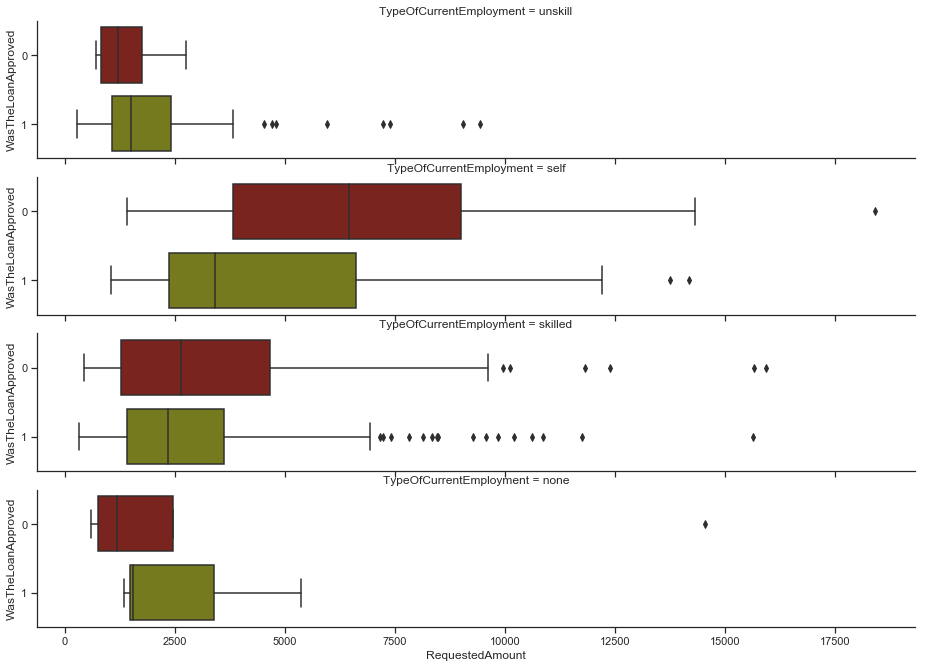

In [126]:
g = sns.catplot(x="RequestedAmount", y="WasTheLoanApproved", row="TypeOfCurrentEmployment",
                kind="box", orient="h", height = 4, aspect = 0.9 , data = train_new)
g.fig.set_size_inches(16, 9)

The above plot offers some interesting insights - 
* Applicants with unskilled employment tend to apply for loans with amounts below $\$5000$, a low amount seems to improve their chances of approval. The mean amount for which they do get approved is the lowest << $\$2500$.
* Applicants who are currently unemployed tend to apply for loans with amounts up to $\$15000$. However, probably due to their unemployed status, almost all loan applications with the amount > $\$5000$ seem to lead to a rejection. The mean amount for which they do get approved is the 2nd lowest < $\$2500$.
* The highest mean loan amount that is approved is for the self employed applicants. They also have the highest mean loan amount that gets rejected, leading to the assumption that they tend to apply for loans with higher amounts than other categories.

Let us look at some of the **reasons** these categories of applicants, apply for loans by adding `LoanReason` to the mix.

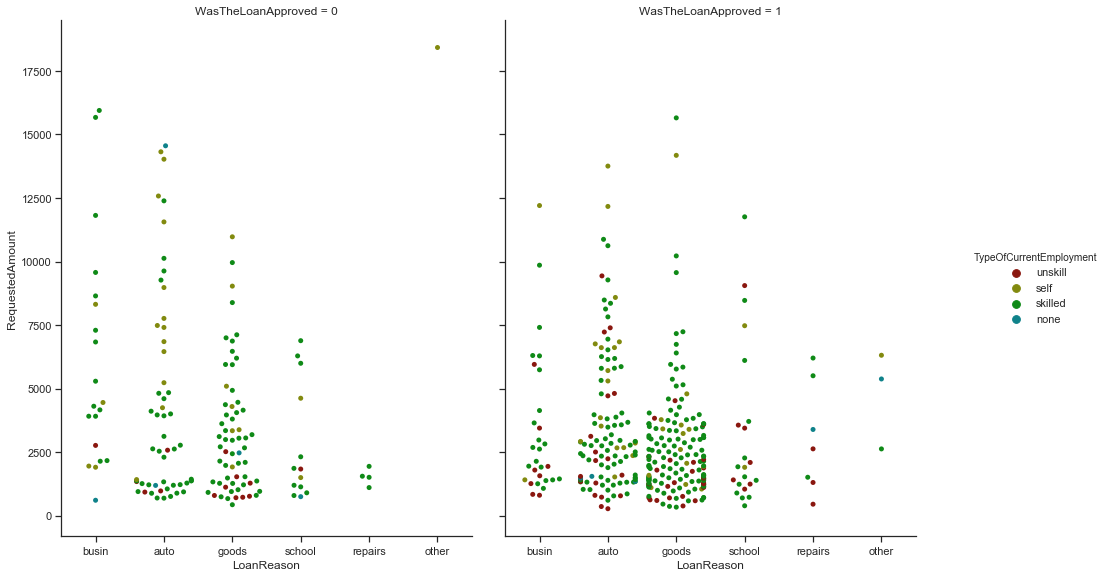

In [127]:
g = sns.catplot(x="LoanReason", y="RequestedAmount", hue="TypeOfCurrentEmployment",
            col="WasTheLoanApproved",
            kind="swarm", data=train_new)
g.fig.set_size_inches(16, 9)

Once again, this is not very clear. Here are some assumptions we can draw from these visuals.
* Unskilled applicants tend to form a significant proportion of people applying for school or business loans. They apply for small amounts and tend to get approved.
* When self-employed applicants apply for auto or goods loans with amounts > $\$5000$, they tend to get rejected.

Let us shift our focus to the finances of our applicants and see if we can isolate any patterns in those features. Let us first look at `InterestRate`.

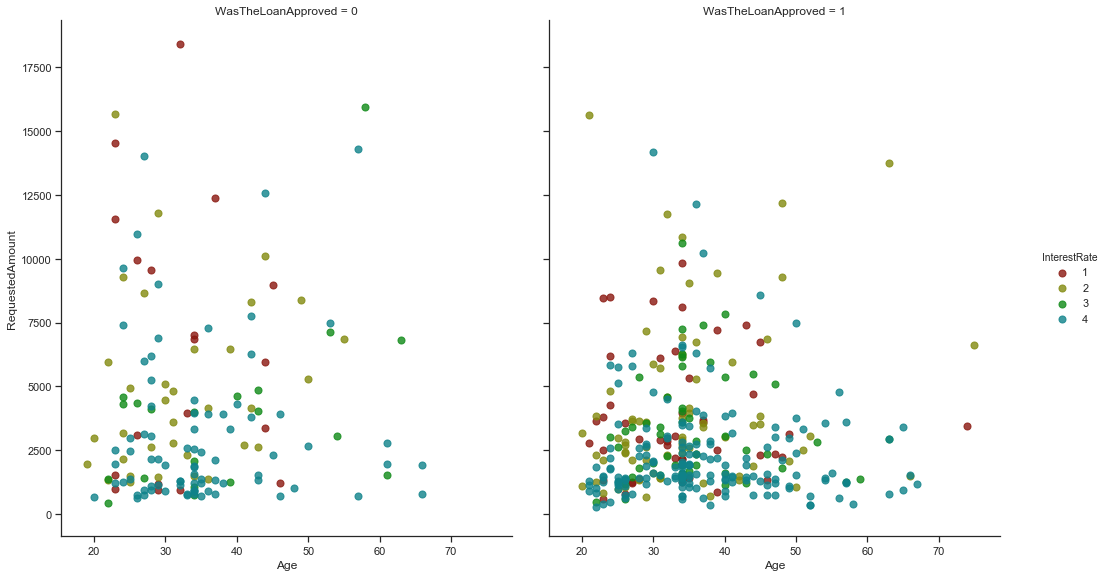

In [128]:
g = sns.lmplot(data = train_new, x = "Age", y = "RequestedAmount", 
               hue = "InterestRate", col="WasTheLoanApproved",
               scatter_kws = {'s':50}, fit_reg=False)
g.fig.set_size_inches(16, 9)

Unsurprisingly, the bank seems to approve **high interest, low amount** loans and tends to reject **low interest, high amount** loans. This seems to be a way to mitigate overall risk as a large number of **high interest, low amount** loans - 
* Bring in more revenue for the bank
* Are less risky.

We can also see that almost all applications where the `RequestedAmount` > $\$7500$ and the `InterestRate` == > $1\%$ were rejected. Probably because a few **low interest, high amount** loans do not bring in enough revenue to justify the risk.

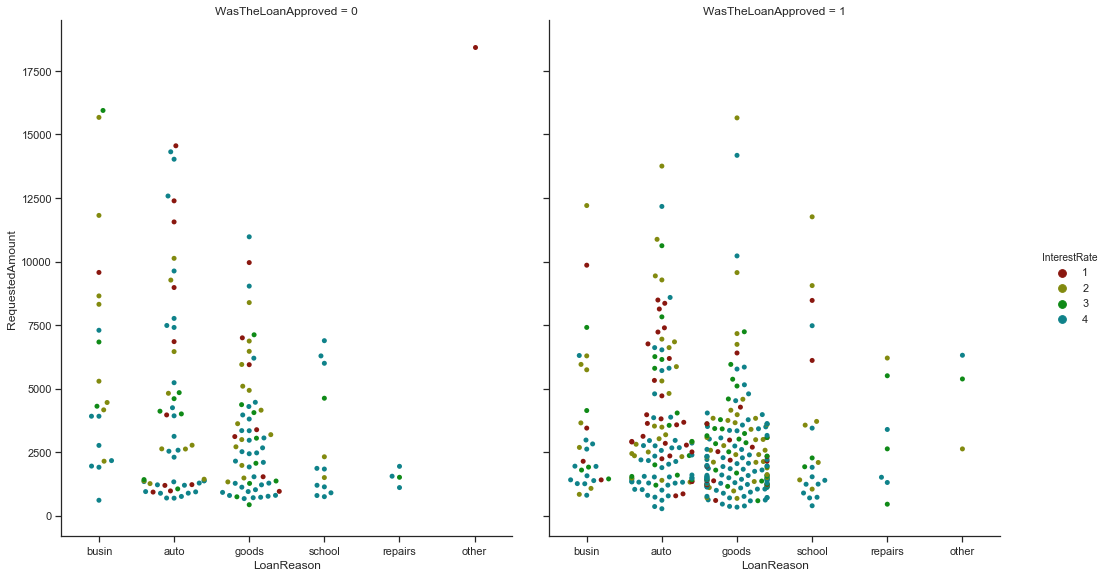

In [129]:
g = sns.catplot(x="LoanReason", y="RequestedAmount", hue="InterestRate",
            col="WasTheLoanApproved",
            kind="swarm", data=train_new)
g.fig.set_size_inches(16, 9)

Let us explore `SavingsAccountBalance`, in my opinion it is a stronger indicator than `CheckingAccountBalance` because - 
* `CheckingAccountBalance` will have a higher degree of **churn** than `SavingsAccountBalance`, i.e, Savings account balances may not decrease, but grow over time, whereas `CheckingAccountBalance` may follow monthly cyclical patterns due to bills, expenses etc.
* Since this is categorical data, the likelihood of savings account balances jumping from category to category is lower than the same for checking account balances.

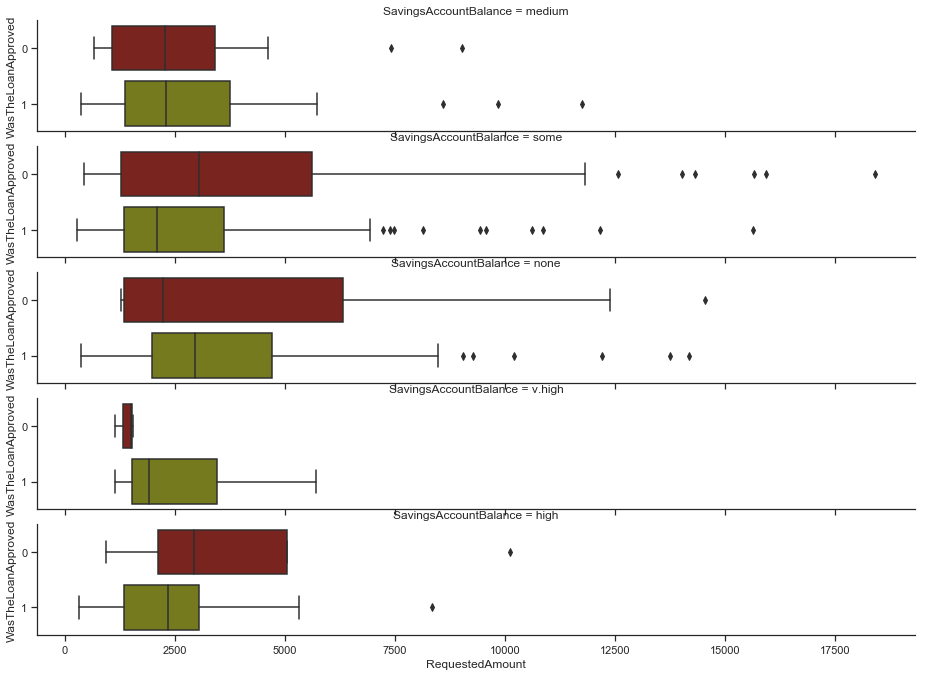

In [130]:
g = sns.catplot(x="RequestedAmount", y="WasTheLoanApproved", row="SavingsAccountBalance",
                kind="box", orient="h", height = 4, aspect = 0.9 , data = train_new)
g.fig.set_size_inches(16, 9)

The above graphic is very helpful and we can make the following assumptions - 
* Applicants with `some` or `none` or `medium` savings tend to apply for loans of all amounts but get rejected for loans of higher amounts.
* Applicants with `high` or `v. high` savings tend to apply for loans of small amounts, however surprisingly on average, they tend to get rejected for smaller loans.

From these observations, we can surmise that `SavingsAccountBalance` plays a clear, important role in the loan approval process. Let us now add `CheckingAccountBalance` to the mix and see how that changes our picture.

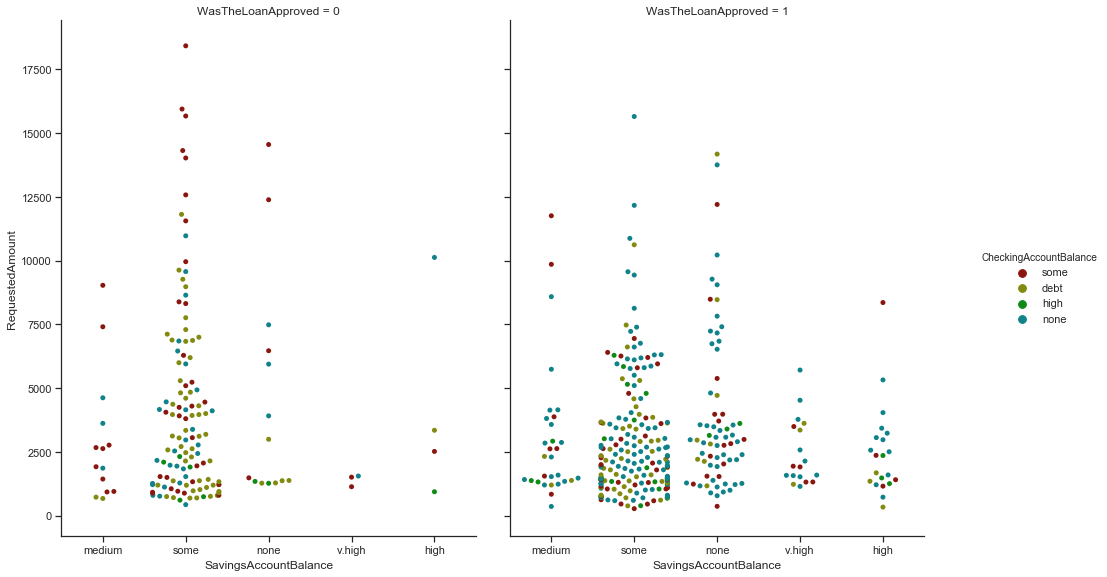

In [131]:
g = sns.catplot(x = "SavingsAccountBalance", y="RequestedAmount", hue="CheckingAccountBalance",
            col="WasTheLoanApproved",
            kind="swarm", data=train_new)
g.fig.set_size_inches(16, 9)

We can observe - 
* Barring some cases, having `debt` in `CheckingAccountBalance` seems to lead to a rejection of the loan application.
* Applicants with no checking account balance tend to borrow low amounts and do get approved. It is similar for people with people with high checking account balance.

Let us now explore the relationships between `LoanPayoffPeriodInMonths` and other features. In the plot below we explore how `LoanPayoffPeriodInMonths` relates to `RequestedAmount` and how that may impact approval. We can observe that loans for higher time periods have higher rates. Also, short time period loans, with low amounts tend to get approved while shorter loans with low interest rates for higher values tend to get rejected.

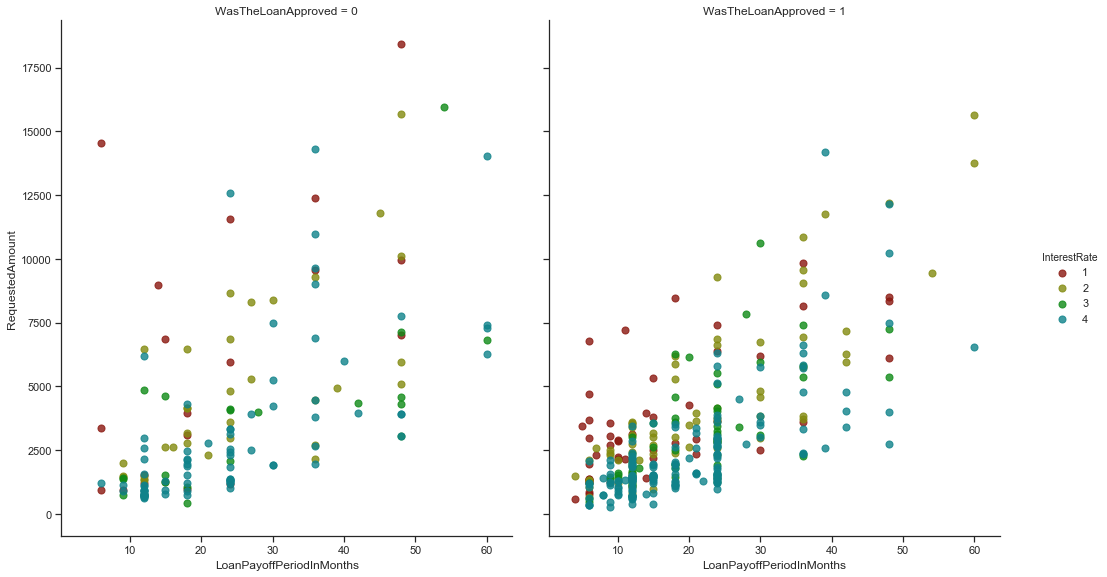

In [132]:
g = sns.lmplot(data = train_new, x = "LoanPayoffPeriodInMonths", y = "RequestedAmount", 
               hue = "InterestRate", col="WasTheLoanApproved",
               scatter_kws = {'s':50}, fit_reg=False)
g.fig.set_size_inches(16, 9)

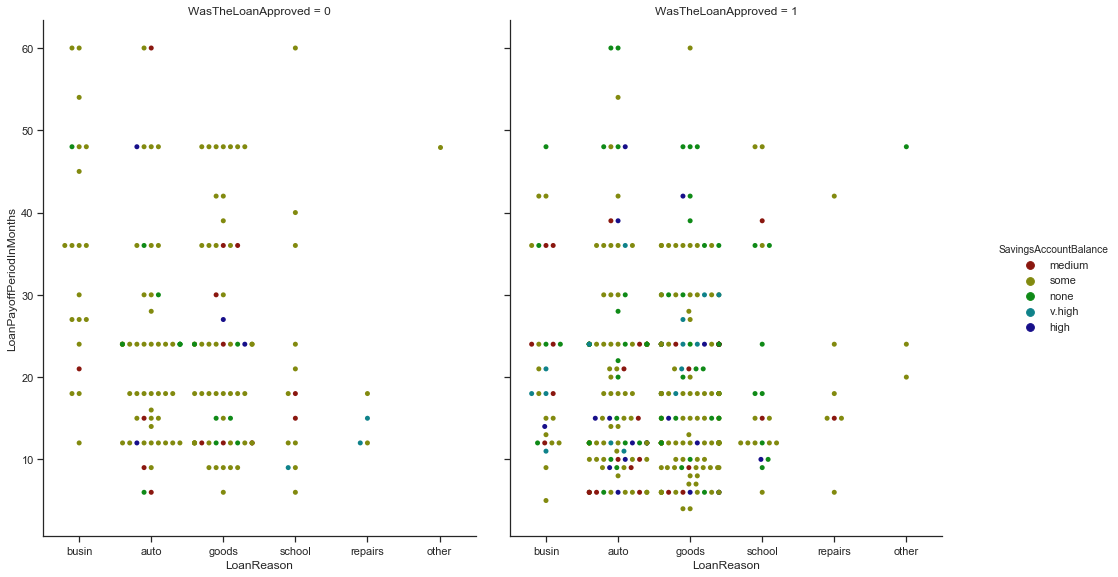

In [133]:
g = sns.catplot(x = "LoanReason", y="LoanPayoffPeriodInMonths", hue="SavingsAccountBalance",
            col="WasTheLoanApproved",
            kind="swarm", data=train_new)
g.fig.set_size_inches(16, 9)

The above graphic helps us understand that - 
* Long term auto loans tend to get rejected probably because vehicles depreciate in value very rapidly.
* Applicants with very high savings tend to get approved for long term loans.

Finally, let us explore `DebtsPaid`, `CurrentOpenLoanApplications` and see how they relate to the other features.

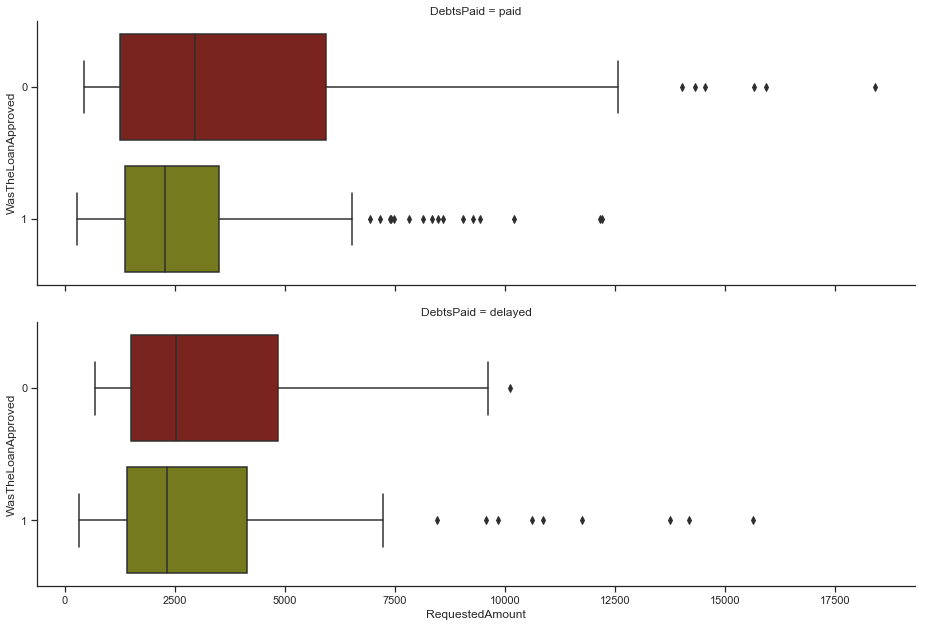

In [134]:
g = sns.catplot(x="RequestedAmount", y="WasTheLoanApproved", row="DebtsPaid",
                kind="box", orient="h", height = 4, aspect = 0.9 , data = train_new)
g.fig.set_size_inches(16, 9)

Surprisingly, getting delayed on paying back debt doesn't seem to have the effect we're looking for. It seems that on average, applicants with a delay in paying back their debts have a similar loan amount approved as those who pay their debts on time.

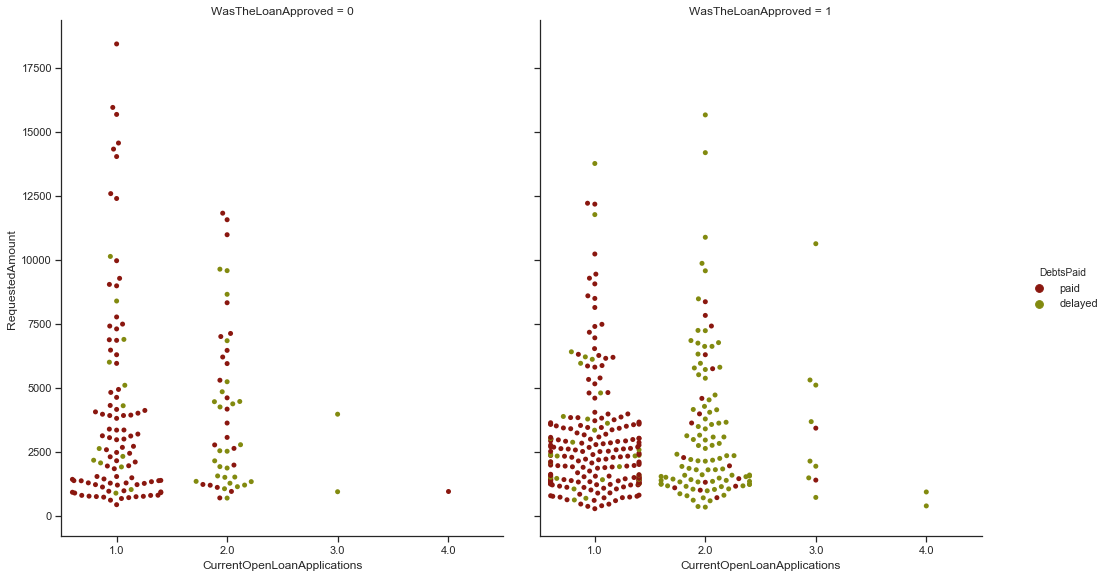

In [135]:
g = sns.catplot(x = "CurrentOpenLoanApplications", y="RequestedAmount", hue="DebtsPaid",
            col="WasTheLoanApproved",
            kind="swarm", data=train_new)
g.fig.set_size_inches(16, 9)

Having multiple open loan applications along with having delayed payments also doesn't seem to impact loan approval as there are plenty of applicants who have been approved inspite of being delayed and having multiple open loans. Unfortunately, applicants with only a single loan, who have paid off their debts seem to have a high probability of getting rejected when they apply for loans with high amounts.

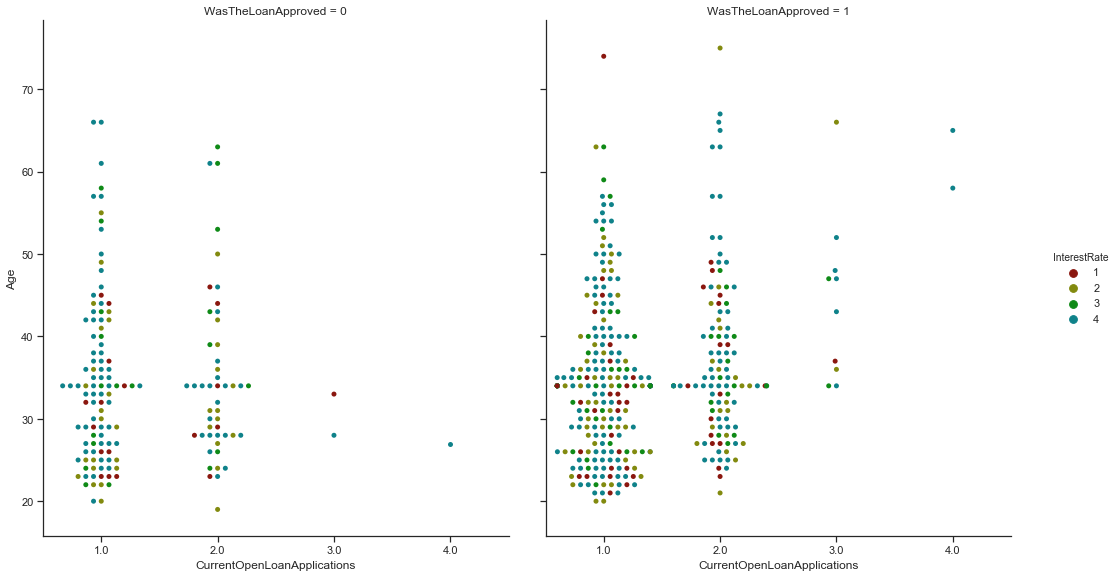

In [136]:
g = sns.catplot(x = "CurrentOpenLoanApplications", y="Age", hue="InterestRate",
            col="WasTheLoanApproved",
            kind="swarm", data=train_new)
g.fig.set_size_inches(16, 9)

From this graphic we can observe - 
* Having 2 or more open loan applications leads to a loan approval with higher interest rates.
* Applicants older than 30 tend to have >= 3 open loan applications. They usually get approved but with higher interest rates.

## Building our Classifiers

In [64]:
train_new.dtypes
# train_new

LoanPayoffPeriodInMonths             int64
LoanReason                          object
RequestedAmount                      int64
InterestRate                         int64
Co-Applicant                        object
WasTheLoanApproved                   int64
YearsInCurrentResidence            float64
Age                                float64
NumberOfDependantsIncludingSelf    float64
CurrentOpenLoanApplications        float64
YearsAtCurrentEmployer              object
RentOrOwnHome                       object
TypeOfCurrentEmployment             object
CheckingAccountBalance              object
DebtsPaid                           object
SavingsAccountBalance               object
dtype: object

We use **one hot encoding** to convert categorical variables to numerically encoded values for our model prediction

In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
obj_dtypes = [i for i in train_new.select_dtypes(include = np.object).columns]
for i in obj_dtypes:
    train_new[i] = le.fit_transform(train_new[i])
    test_new[i] = le.fit_transform(test_new[i])
    blind_new[i] = le.fit_transform(blind_new[i])
train_new = pd.get_dummies(data=train_new,columns=obj_dtypes)
test_new = pd.get_dummies(data=test_new,columns=obj_dtypes)
blind_new = pd.get_dummies(data=blind_new,columns=obj_dtypes)

In [66]:
train_new.dtypes

LoanPayoffPeriodInMonths             int64
RequestedAmount                      int64
InterestRate                         int64
WasTheLoanApproved                   int64
YearsInCurrentResidence            float64
Age                                float64
NumberOfDependantsIncludingSelf    float64
CurrentOpenLoanApplications        float64
LoanReason_0                         uint8
LoanReason_1                         uint8
LoanReason_2                         uint8
LoanReason_3                         uint8
LoanReason_4                         uint8
LoanReason_5                         uint8
Co-Applicant_0                       uint8
Co-Applicant_1                       uint8
Co-Applicant_2                       uint8
YearsAtCurrentEmployer_0             uint8
YearsAtCurrentEmployer_1             uint8
YearsAtCurrentEmployer_2             uint8
YearsAtCurrentEmployer_3             uint8
YearsAtCurrentEmployer_4             uint8
RentOrOwnHome_0                      uint8
RentOrOwnHo

In [67]:
test_new.dtypes

LoanPayoffPeriodInMonths             int64
RequestedAmount                      int64
InterestRate                         int64
WasTheLoanApproved                   int64
YearsInCurrentResidence            float64
Age                                float64
NumberOfDependantsIncludingSelf    float64
CurrentOpenLoanApplications        float64
LoanReason_0                         uint8
LoanReason_1                         uint8
LoanReason_2                         uint8
LoanReason_3                         uint8
LoanReason_4                         uint8
LoanReason_5                         uint8
Co-Applicant_0                       uint8
Co-Applicant_1                       uint8
Co-Applicant_2                       uint8
YearsAtCurrentEmployer_0             uint8
YearsAtCurrentEmployer_1             uint8
YearsAtCurrentEmployer_2             uint8
YearsAtCurrentEmployer_3             uint8
YearsAtCurrentEmployer_4             uint8
RentOrOwnHome_0                      uint8
RentOrOwnHo

In [68]:
blind_new.dtypes

LoanPayoffPeriodInMonths             int64
RequestedAmount                      int64
InterestRate                         int64
WasTheLoanApproved                   int64
YearsInCurrentResidence            float64
Age                                float64
NumberOfDependantsIncludingSelf    float64
CurrentOpenLoanApplications        float64
LoanReason_0                         uint8
LoanReason_1                         uint8
LoanReason_2                         uint8
LoanReason_3                         uint8
LoanReason_4                         uint8
LoanReason_5                         uint8
Co-Applicant_0                       uint8
Co-Applicant_1                       uint8
Co-Applicant_2                       uint8
YearsAtCurrentEmployer_0             uint8
YearsAtCurrentEmployer_1             uint8
YearsAtCurrentEmployer_2             uint8
YearsAtCurrentEmployer_3             uint8
YearsAtCurrentEmployer_4             uint8
RentOrOwnHome_0                      uint8
RentOrOwnHo

As we can see, one hot encoding, expands our data set by applying coded values to categorical variables. We now separate the predictor variables ($X$) and target variable ($Y$) into separate dataframe for our train, test and blind data sets.

In [69]:
x_train = train_new[[i for i in train_new.columns if i not in ['WasTheLoanApproved']]]
y_train = train_new.WasTheLoanApproved

x_test = test_new[[i for i in test_new.columns if i not in ['WasTheLoanApproved']]]
y_test = test_new.WasTheLoanApproved

x_blind = blind_new[[i for i in blind_new.columns if i not in ['WasTheLoanApproved']]]
y_blind = blind_new.WasTheLoanApproved

In the snippet below, I write a `model` function that takes as input the classification algorithm, $X$/$Y$ train/test/blind data sets. The function - 
1. Fits the model to the training dataset.
2. Makes predictions for the test dataset.
3. Makes predictions for the blind dataset.
4. Calculates quality metrics
    * Accuracy score
    * Recall score
    * Classification report containing a detailed summary.
5. Plots the AUC and ROC Curve.
6. Writes the test predictions to a file.
7. Writes the blind predictions to a file.

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score, classification_report, roc_curve, auc

def model(algorithm, dtrain_X, dtrain_Y, dtest_X, dtest_Y, blind_X, blind_Y, algo = 0, iterative = False):
    cols = dtrain_X.columns
    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols]) # Predictions for the test dataset
    blindPredictions = algorithm.predict(blind_X[cols]) # Predictions for the blind dataset
    if(iterative == False):
        print (algorithm)

        print ("Accuracy score : ", round(accuracy_score(dtest_Y, predictions), 3))
        print ("Recall score   : ", round(recall_score(dtest_Y, predictions), 3))
        print ("classification report :\n", classification_report(dtest_Y, predictions))

        fig = plt.figure(figsize=(16, 9))
        ax  = fig.add_subplot(111)
        prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
        fpr, tpr, thresholds = roc_curve(dtest_Y,prediction_probabilities)
        ax.plot(fpr, tpr, label = [" Area under curve : ", round(auc(fpr, tpr), 3)], linewidth = 4, linestyle = "dotted")
        ax.plot([0,1],[0,1],linewidth = 4, linestyle = "dashed")
        plt.legend(loc = "best")
        plt.title("ROC-CURVE & AREA UNDER CURVE")
        
        fname = ""
        if(algo == 1):
            fname = "logit"
        elif(algo == 2):
            fname = "randomForest"

        s0 = dtest_Y.reset_index(level=0)
        s1 = pd.Series(predictions, name = 'predicted')
        pd.concat([s0, s1], axis = 1).to_csv(fname + "modelPred.csv", sep=',', index = False) # Save predictions to file

        s2 = blind_Y.reset_index(level=0)
        s3 = pd.Series(blindPredictions, name = 'predicted')
        pd.concat([s2.CustomerID, s3], axis = 1).to_csv(fname + "blindPred.csv", sep=',', index = False) # Save blind test predictions to file

    return classification_report(dtest_Y, predictions, output_dict = True)

### Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy score :  0.735
Recall score   :  0.945
classification report :
               precision    recall  f1-score   support

           0       0.75      0.32      0.45        56
           1       0.73      0.95      0.83       110

   micro avg       0.73      0.73      0.73       166
   macro avg       0.74      0.63      0.64       166
weighted avg       0.74      0.73      0.70       166



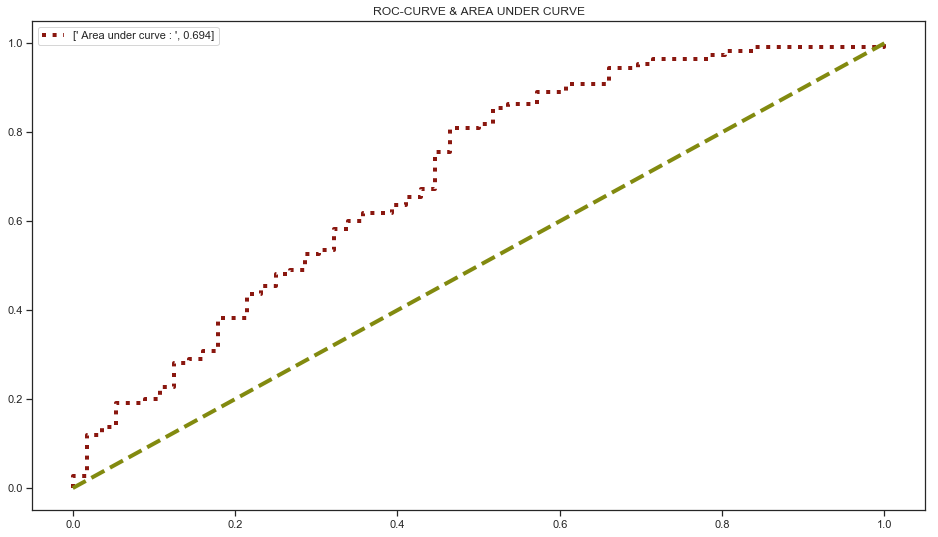

In [71]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logitModel = model(logit, x_train, y_train, x_test, y_test, x_blind, y_blind, algo = 1)

These are the results of the **Logistic Regression** classifier. Our accuracy is near $80\%$. However, as our data has some imbalance, better metrics to judge our model are **AUC** (area under the ROC curve), **Weighted-Avg. Precision**, **Weighted-Avg. Recall** and **Weighted-Avg. f1-score**. In the next snippet of code, I run this model on our data $10,000$ times. This isn't necessary to do, but it gives us strong **average** values of what precision, recall and f1-score look like over multiple iterations.

In [251]:
start = time.time()
precision = 0
recall = 0
f1 = 0
runs = 10000
for i in range(runs):
    logitModel = model(logit, x_train, y_train, x_test, y_test, x_blind, y_blind, iterative = True)
    precision += logitModel['weighted avg']['precision']
    recall += logitModel['weighted avg']['recall']
    f1 += logitModel['weighted avg']['f1-score']
stop = time.time()
logitpAvg = round(precision/runs, 4)
logitrAvg = round(recall/runs, 4)
logitfAvg = round(f1/runs, 4)

In [252]:
print("Precision Average :", logitpAvg)
print("Recall Average :", logitrAvg)
print("f1-score Average :", logitfAvg)
print("Time Elapsed :", round(stop - start, 3), "seconds.")

Precision Average : 0.7262
Recall Average : 0.741
f1-score Average : 0.7312
Time Elapsed : 189.388 seconds.


These values are averaged out over $10,000$ iterations and are indicative of the precision, recall values we would see if we applied our model to the blind loan dataset. These numbers are indicative of the quality of this model and one way to judge if this model is any good is to compare it against a baseline. We will implement a Monte-Carlo random classifier later and see if this model beats our baseline.

### Random Forest Classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy score :  0.729
Recall score   :  0.891
classification report :
               precision    recall  f1-score   support

           0       0.66      0.41      0.51        56
           1       0.75      0.89      0.81       110

   micro avg       0.73      0.73      0.73       166
   macro avg       0.70      0.65      0.66       166
weighted avg       0.72      0.73      0.71       166



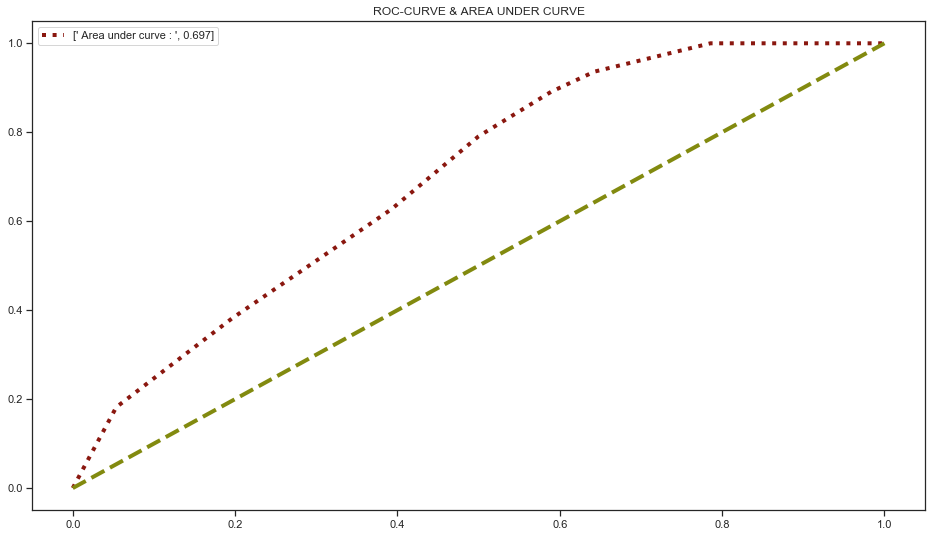

In [72]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfcModel = model(rfc, x_train, y_train, x_test, y_test, x_blind, y_blind, algo = 2)

These are the results of the **Random Forest** classifier. Our accuracy is near $75\%$. However, as our data has some imbalance, better metrics to judge our model are **AUC** (area under the ROC curve), **Weighted-Avg. Precision**, **Weighted-Avg. Recall** and **Weighted-Avg. f1-score**. In the next snippet of code, I run this model on our data $10,000$ times. Once again this isn't necessary to do, but it gives us strong **average** values of what precision, recall and f1-score look like over multiple iterations.

In [261]:
start = time.time()
precision = 0
recall = 0
f1 = 0
runs = 10000
for i in range(runs):
    rfcModel = model(rfc, x_train, y_train, x_test, y_test, x_blind, y_blind, iterative = True)
    precision += rfcModel['weighted avg']['precision']
    recall += rfcModel['weighted avg']['recall']
    f1 += rfcModel['weighted avg']['f1-score']
stop = time.time()
rfcpAvg = round(precision/runs, 4)
rfcrAvg = round(recall/runs, 4)
rfcfAvg = round(f1/runs, 4)

In [262]:
print("Precision Average :", rfcpAvg)
print("Recall Average :", rfcrAvg)
print("f1-score Average :", rfcfAvg)
print("Time Elapsed :", round(stop - start, 3), "seconds.")

Precision Average : 0.7036
Recall Average : 0.6931
f1-score Average : 0.6973
Time Elapsed : 392.723 seconds.


Using a Random Forest Classifier, we can visualize the importance of the features that we have used in building our model.

Text(0.5, 1.0, 'Feature Importance')

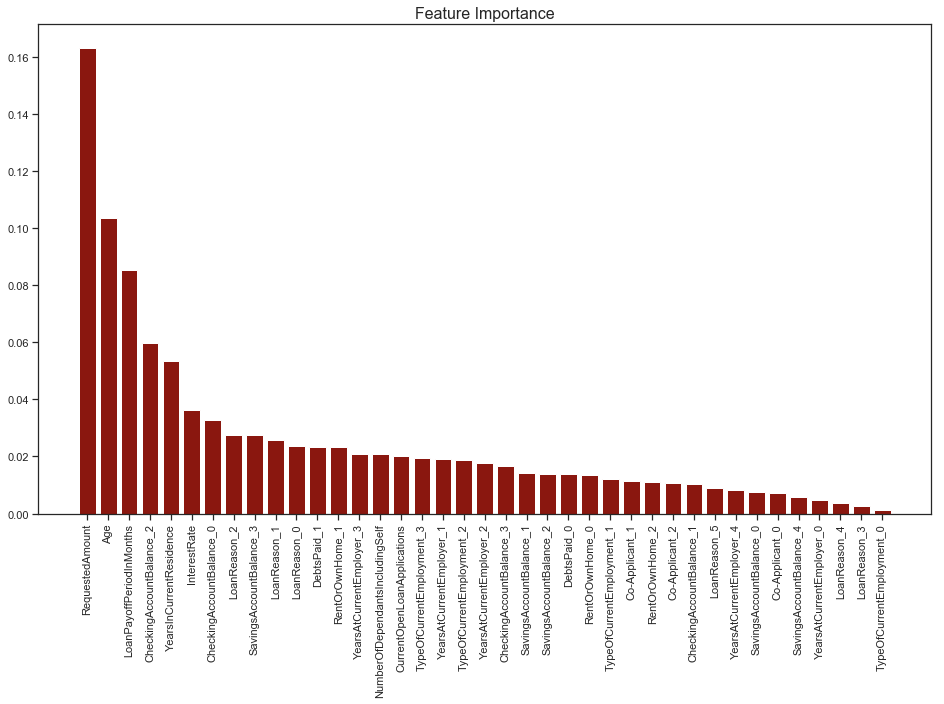

In [73]:
# Plot features importance
importances = rfc.feature_importances_
indices = np.argsort(rfc.feature_importances_)[::-1]
plt.bar(range(1, len(importances)+1), importances[indices], align="center")
plt.xticks(range(1, len(importances)+1),
           train_new.columns[train_new.columns != "WasTheLoanApproved"][indices],
           rotation=90)
plt.title("Feature Importance", {"fontsize": 16})

The plot above tells us which features contributed were the most important for our Random Forest Model. `RequestedAmount`, `LoanPeriod` and `Age` played the most important roles. The top 5 most important features are all numerical in type.

A plot like this is helpful in many ways, namely - 
* It helps us judge if the assumptions we made at the beginning were correct.
* It tells us which features we can remove, if they do not contribute value to our model.
* It can help us refine our approach and our model.

In the plot above, we can see that almost all features have some degree of importance in the overall model. However, if we did have a case where we have many features, we could use a plot like this to choose the most important features and act accordingly.

### Monte-Carlo Random Prediction baseline

One way to check if our classifiers are any good, is to answer the question, **"Are our results better than random guesses?"** To answer this question, we randomly assign a loan approval/denial to the customers in our test set and compare against the actual results.

In [264]:
import random
randomGuess = [random.randint(0, 1) for _ in range(x_test.shape[0])] #A random loan approval for each customer in the Test set
print(classification_report(y_test, randomGuess))

              precision    recall  f1-score   support

           0       0.26      0.40      0.31        45
           1       0.72      0.57      0.64       121

   micro avg       0.52      0.52      0.52       166
   macro avg       0.49      0.49      0.47       166
weighted avg       0.59      0.52      0.55       166



Looking at the weighted averages, we can confirm that the values are lower than those given by our logistic regression and random forest classifiers. Now, by running this $5,000$ or $10,000$ times, we can get a better picture of what a truly **random** guess implies and whether our classifiers beat such a value and are therefore better than a random guess.

In [265]:
start = time.time()
precision = 0
recall = 0
f1 = 0
runs = 10000
for i in range(runs):
    randomGuess = [random.randint(0, 1) for _ in range(x_test.shape[0])]
    report = classification_report(y_test, randomGuess, output_dict = True)
    precision += report['weighted avg']['precision']
    recall += report['weighted avg']['recall']
    f1 += report['weighted avg']['f1-score']
stop = time.time()
pAvg = round(precision/runs, 4)
rAvg = round(recall/runs, 4)
fAvg = round(f1/runs, 4)
print("Precision Average :", pAvg)
print("Recall Average :", rAvg)
print("f1-score Average :", fAvg)
print("Time Elapsed :", round(stop - start, 3), "seconds.")

Precision Average : 0.6046
Recall Average : 0.4997
f1-score Average : 0.5265
Time Elapsed : 47.019 seconds.


From the above Monte-Carlo simulation, we can conclude 2 things - 
* Both our classifiers have better results than a random guess.
* The precision, recall and f1-score values, are close to the $H|T$ probabilities we would observe if we flipped a coin $10,000$ times.

## Conclusion

In [266]:
table = PrettyTable()
table.field_names = ["Algorithm", "Precision", "Recall", "f1-Score"]
table.add_row(["Monte Carlo Random Classifier", pAvg, rAvg, fAvg])
table.add_row(["Logistic Regression Classifier", logitpAvg, logitrAvg, logitfAvg])
table.add_row(["Random Forest Classifier", rfcpAvg, rfcrAvg, rfcfAvg])
print(table)

+--------------------------------+-----------+--------+----------+
|           Algorithm            | Precision | Recall | f1-Score |
+--------------------------------+-----------+--------+----------+
| Monte Carlo Random Classifier  |   0.6046  | 0.4997 |  0.5265  |
| Logistic Regression Classifier |   0.7262  | 0.741  |  0.7312  |
|    Random Forest Classifier    |   0.7036  | 0.6931 |  0.6973  |
+--------------------------------+-----------+--------+----------+


In conclusion, it would be apt to say that both our classifiers do a better job than Monte-Carlo Random Classifiers. Both Logistic Regression and Random Forests have precision and recall in the $70-80\%$ range. For a small dataset like the one above, these would be satisfactory numbers. That being said, there are opportunities where additional steps can be taken to fine tune the classification model. We can try more creative ways of handling missing data or use down-sampling/up-sampling to better improve our predictions. Data quality and quantity however would play an integral role. More data would help us capture more nuances in the universe. Better data would strengthen our claims.